In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/THESIS/rag-thesis'

/content/drive/MyDrive/THESIS/rag-thesis


In [ ]:
!pip install -q -U -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement tdqdm (

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from forecasting_utils import *



In [6]:
import json
# Extract results from JSON files
with open("results/ar1_results.json", "r") as file:
    ar1_results = json.load(file)

with open("results/bvar_results.json", "r") as file:
    bvar_results = json.load(file)

with open("results/arima_results.json", "r") as file:
    arima_results = json.load(file)

with open("results/timesfm_results.json", "r") as file:
    timesfm_results = json.load(file)

with open("results/timegpt_results.json", "r") as file:
    timegpt_results = json.load(file)

with open("results/moirai_results.json", "r") as file:
    moirai_results = json.load(file)

with open("results/chronos_results.json", "r", encoding="utf-8") as file:
    chronos_results = json.load(file)

##### RAG RESULTS

with open("results/rag_forecasting/timegpt_rag_results.json", "r") as file:
    timegpt_rag_results = json.load(file)

with open("results/rag_forecasting/timesfm_rag_results.json", "r") as file:
    timesfm_rag_results = json.load(file)

with open("results/rag_forecasting/chronos_rag_results.json", "r") as file:
    chronos_rag_results = json.load(file)

with open("results/rag_forecasting/moirai_rag_results.json", "r") as file:
    moirai_rag_results = json.load(file)

# Get General Distribution Metrics

In [7]:
results = chronos_rag_results
for h in [1,3,6,12]:
    print(f"horizon: {h}")
    print("Median: ", np.percentile(results[f"h={h}"]['RMSE'], 50))
    print("Std: ", np.std(results[f"h={h}"]['RMSE']))
    print("Min: ", np.min(results[f"h={h}"]['RMSE']))
    print("Max: ", np.max(results[f"h={h}"]['RMSE']))
    print("---------------------------------")


horizon: 1
Median:  1.0413389650090654
Std:  0.12994626667917183
Min:  0.994110013669704
Max:  1.3692794410037137
---------------------------------
horizon: 3
Median:  1.0616307400075153
Std:  0.10203933082098007
Min:  1.0020081017594813
Max:  1.3148295986307834
---------------------------------
horizon: 6
Median:  1.0206110889399542
Std:  0.17198660789474948
Min:  0.8906727348958223
Max:  1.48673130080479
---------------------------------
horizon: 12
Median:  1.026342224723733
Std:  0.02687065095488166
Min:  1.0013556028788186
Max:  1.072086529640532
---------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


# Approximate data based on the plots
# Format: [median, Q1, Q3, min, max, (outliers)]

data = {
    'bvar': {
        h: [np.percentile(bvar_results[f"h={h}"]['RMSE'], 50),
            np.percentile(bvar_results[f"h={h}"]['RMSE'], 25),
            np.percentile(bvar_results[f"h={h}"]['RMSE'], 75),
            np.min(bvar_results[f"h={h}"]['RMSE']),
            np.max(bvar_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'arima': {
        h: [np.percentile(arima_results[f"h={h}"]['RMSE'], 50),
            np.percentile(arima_results[f"h={h}"]['RMSE'], 25),
            np.percentile(arima_results[f"h={h}"]['RMSE'], 75),
            np.min(arima_results[f"h={h}"]['RMSE']),
            np.max(arima_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'timesfm': {
        h: [np.percentile(timesfm_results[f"h={h}"]['RMSE'], 50),
            np.percentile(timesfm_results[f"h={h}"]['RMSE'], 25),
            np.percentile(timesfm_results[f"h={h}"]['RMSE'], 75),
            np.min(timesfm_results[f"h={h}"]['RMSE']),
            np.max(timesfm_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'timegpt': {
        h: [np.percentile(timegpt_results[f"h={h}"]['RMSE'], 50),
            np.percentile(timegpt_results[f"h={h}"]['RMSE'], 25),
            np.percentile(timegpt_results[f"h={h}"]['RMSE'], 75),
            np.min(timegpt_results[f"h={h}"]['RMSE']),
            np.max(timegpt_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'moirai': {
        h: [np.percentile(moirai_results[f"h={h}"]['RMSE'], 50),
            np.percentile(moirai_results[f"h={h}"]['RMSE'], 25),
            np.percentile(moirai_results[f"h={h}"]['RMSE'], 75),
            np.min(moirai_results[f"h={h}"]['RMSE']),
            np.max(moirai_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'chronos': {
        h: [np.percentile(chronos_results[f"h={h}"]['RMSE'], 50),
            np.percentile(chronos_results[f"h={h}"]['RMSE'], 25),
            np.percentile(chronos_results[f"h={h}"]['RMSE'], 75),
            np.min(chronos_results[f"h={h}"]['RMSE']),
            np.max(chronos_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    }
}

# Define colors
bvar_color = "#efc529"
arima_color = '#3498db'   # Sky blue
timesfm_color = '#9b59b6' # Light purple
timegpt_color = '#27d52c'
moirai_color = '#ee4fee'
chronos_color = '#f25920'


horizons = [1, 3, 6, 12]
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=1000)
axes = axes.flatten()

for i, h in enumerate(horizons):
    ax = axes[i]
    ax.axhline(y=1, color='black', linestyle='-', alpha=0.2,zorder=0)
    # Define positions for ARIMA and TimesFM
    positions = [0.1, 0.4, 0.7, 1, 1.3, 1.6]

    # Create boxplots
    bvar_plot = ax.boxplot([bvar_results[f"h={h}"]['RMSE']],
                            positions=[positions[0]],
                            widths=0.2,
                            patch_artist=True,
                            showfliers=False,
                            zorder=2)

    arima_plot = ax.boxplot([arima_results[f"h={h}"]['RMSE']],
                            positions=[positions[1]],
                            widths=0.2,
                            patch_artist=True,
                            showfliers=False,
                            zorder=2)

    timesfm_plot = ax.boxplot([timesfm_results[f"h={h}"]['RMSE']],
                              positions=[positions[2]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)

    timegpt_plot = ax.boxplot([timegpt_results[f"h={h}"]['RMSE']],
                              positions=[positions[3]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)

    moirai_plot = ax.boxplot([moirai_results[f"h={h}"]['RMSE']],
                              positions=[positions[4]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)

    chronos_plot = ax.boxplot([chronos_results[f"h={h}"]['RMSE']],
                              positions=[positions[5]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)

    # Define custom legend elements
    legend_elements = [
        Patch(facecolor=bvar_color, edgecolor='#bb9c29', label='BVAR'),
        Patch(facecolor=arima_color, edgecolor='#21618C', label='ARIMA'),
        Patch(facecolor=timesfm_color, edgecolor='#6C3483', label='TimesFM'),
        Patch(facecolor=timegpt_color, edgecolor='#1c8e20', label='TimeGPT'),
        Patch(facecolor=moirai_color, edgecolor='#8d2a8d', label='Moirai'),
        Patch(facecolor=chronos_color, edgecolor='#d04f1f', label='Chronos')
    ]

    # Style BVAR boxes
    for box, median in zip(bvar_plot['boxes'], bvar_plot['medians']):
        box.set_facecolor(bvar_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#bb9c29')
        median.set_color('#bb9c29')

    # Style ARIMA boxes
    for box, median in zip(arima_plot['boxes'], arima_plot['medians']):
        box.set_facecolor(arima_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#21618C')
        median.set_color('#21618C')

    # Style TimesFM boxes
    for box, median in zip(timesfm_plot['boxes'], timesfm_plot['medians']):
        box.set_facecolor(timesfm_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#6C3483')
        median.set_color('#6C3483')

    # Style TimeGPT boxes
    for box, median in zip(timegpt_plot['boxes'], timegpt_plot['medians']):
        box.set_facecolor(timegpt_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#1c8e20')
        median.set_color('#1c8e20')

    # Style Moirai boxes
    for box, median in zip(moirai_plot['boxes'], moirai_plot['medians']):
        box.set_facecolor(moirai_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#8d2a8d')
        median.set_color('#8d2a8d')

    # Style Chronos boxes
    for box, median in zip(chronos_plot['boxes'], chronos_plot['medians']):
        box.set_facecolor(chronos_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#d04f1f')
        median.set_color('#d04f1f')

    ax.set_title(f'Horizon = {h}')
    ax.set_ylabel('RMSE Ratio')
    ax.set_xticks([])
    #ax.set_ylim(0.3,1.6)
    ax.grid(axis='y', linestyle='-', alpha=0.3)

    if i == 0:
        ax.legend(handles=legend_elements, loc='lower left')

    # Set fewer y-ticks
    #ax.set_yticks([0.6, 0.9, 1, 1.2, 1.5])



plt.tight_layout()
plt.show()


# RAG Boxplot Distribution

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


# Approximate data based on the plots
# Format: [median, Q1, Q3, min, max, (outliers)]

data = {
    'timesfm': {
        h: [np.percentile(timesfm_rag_results[f"h={h}"]['RMSE'], 50),
            np.percentile(timesfm_rag_results[f"h={h}"]['RMSE'], 25),
            np.percentile(timesfm_rag_results[f"h={h}"]['RMSE'], 75),
            np.min(timesfm_rag_results[f"h={h}"]['RMSE']),
            np.max(timesfm_rag_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'timegpt': {
        h: [np.percentile(timegpt_rag_results[f"h={h}"]['RMSE'], 50),
            np.percentile(timegpt_rag_results[f"h={h}"]['RMSE'], 25),
            np.percentile(timegpt_rag_results[f"h={h}"]['RMSE'], 75),
            np.min(timegpt_rag_results[f"h={h}"]['RMSE']),
            np.max(timegpt_rag_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },
    'moirai': {
        h: [np.percentile(moirai_rag_results[f"h={h}"]['RMSE'], 50),
            np.percentile(moirai_rag_results[f"h={h}"]['RMSE'], 25),
            np.percentile(moirai_rag_results[f"h={h}"]['RMSE'], 75),
            np.min(moirai_rag_results[f"h={h}"]['RMSE']),
            np.max(moirai_rag_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    },

    # The following line was causing the error because it was missing a ':'
    # after the dictionary key.  If the user intended to comment this dictionary entry out,
    # they should use '#' on each line instead. Otherwise, they should include a colon and value.
    # I'm assuming they intended to comment it out.
     'chronos': {
         h: [np.percentile(chronos_rag_results[f"h={h}"]['RMSE'], 50),
             np.percentile(chronos_rag_results[f"h={h}"]['RMSE'], 25),
             np.percentile(chronos_rag_results[f"h={h}"]['RMSE'], 75),
             np.min(chronos_rag_results[f"h={h}"]['RMSE']),
             np.max(chronos_rag_results[f"h={h}"]['RMSE'])] for h in [1, 3, 6, 12]
    }
}

# Define colors
bvar_color = "#efc529"
arima_color = '#3498db'   # Sky blue
timesfm_color = '#9b59b6' # Light purple
timegpt_color = '#27d52c'
moirai_color = '#ee4fee'
chronos_color = '#f25920'


horizons = [1, 3, 6, 12]
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=1000)
axes = axes.flatten()

for i, h in enumerate(horizons):
    ax = axes[i]
    ax.axhline(y=1, color='black', linestyle='-', alpha=0.2,zorder=0)
    # Define positions for ARIMA and TimesFM
    positions = [0.7, 1, 1.3, 1.6]

    # Create boxplots
    timesfm_plot = ax.boxplot([timesfm_rag_results[f"h={h}"]['RMSE']],
                              positions=[positions[0]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)

    timegpt_plot = ax.boxplot([timegpt_rag_results[f"h={h}"]['RMSE']],
                              positions=[positions[1]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)


    moirai_plot = ax.boxplot([moirai_rag_results[f"h={h}"]['RMSE']],
                              positions=[positions[2]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)

    chronos_plot = ax.boxplot([chronos_rag_results[f"h={h}"]['RMSE']],
                              positions=[positions[3]],
                              widths=0.2,
                              patch_artist=True,
                              showfliers=False,
                              zorder=2)


    # Define custom legend elements
    legend_elements = [
        Patch(facecolor=timesfm_color, edgecolor='#6C3483', label='TimesFM'),
        Patch(facecolor=timegpt_color, edgecolor='#1c8e20', label='TimeGPT'),
        Patch(facecolor=moirai_color, edgecolor='#8d2a8d', label='Moirai'),
        Patch(facecolor=chronos_color, edgecolor='#d04f1f', label='Chronos')
    ]

    # Style TimesFM boxes
    for box, median in zip(timesfm_plot['boxes'], timesfm_plot['medians']):
        box.set_facecolor(timesfm_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#6C3483')
        median.set_color('#6C3483')

    # Style TimeGPT boxes
    for box, median in zip(timegpt_plot['boxes'], timegpt_plot['medians']):
        box.set_facecolor(timegpt_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#1c8e20')
        median.set_color('#1c8e20')



    # Style Moirai boxes
    for box, median in zip(moirai_plot['boxes'], moirai_plot['medians']):
        box.set_facecolor(moirai_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#8d2a8d')
        median.set_color('#8d2a8d')

    # Style Chronos boxes
    for box, median in zip(chronos_plot['boxes'], chronos_plot['medians']):
        box.set_facecolor(chronos_color)
        box.set_alpha(0.4)
        box.set_edgecolor('#d04f1f')
        median.set_color('#d04f1f')


    ax.set_title(f'Horizon = {h}')
    ax.set_ylabel('RMSE Ratio')
    ax.set_xticks([])
    #ax.set_ylim(0.3,1.6)
    ax.grid(axis='y', linestyle='-', alpha=0.3)

    if i == 0:
        ax.legend(handles=legend_elements, loc='upper left')

    # Set fewer y-ticks
    #ax.set_yticks([0.6, 0.9, 1, 1.2, 1.5])



plt.tight_layout()
plt.show()


### Plot Cumulative RMSEs for each model and variable

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

df_processed = pd.read_csv('/content/drive/MyDrive/THESIS/rag-thesis/data/processed_FRED_data.csv')
train_data, test_data, _ = test_train_split(df_processed, test_size=0.3)

# Sample Dates
dates = test_data[:-13].index

# Variables (excluding last one)
variables = ["GDP_log", "INDPRO_log", "CPILFESL_inflation", "ROWFDIQ027S",
             "IRLTLT01USM156N_diff", "RPI_log", "DFF_diff", "M1V", "AAA_diff"]#, "UNRATE_diff"]  # 8 variables
horizons = ["h=1", "h=3", "h=6", "h=12"]

for horizon in horizons:
    fig, axs = plt.subplots(3, 3, figsize=(14, 10), dpi=600)
    axs = axs.flatten()

    for i, target in enumerate(variables):
        ax = axs[i]

        # Compute point-differences
        bvar_diff = [bvar_results[horizon]['cum_RMSE'][target][0]] + [bvar_results[horizon]['cum_RMSE'][target][i] - bvar_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(bvar_results[horizon]['cum_RMSE'][target]))]
        arima_diff = [arima_results[horizon]['cum_RMSE'][target][0]] + [arima_results[horizon]['cum_RMSE'][target][i] - arima_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(arima_results[horizon]['cum_RMSE'][target]))]
        timegpt_diff = [timegpt_results[horizon]['cum_RMSE'][target][0]] + [timegpt_results[horizon]['cum_RMSE'][target][i] - timegpt_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(timegpt_results[horizon]['cum_RMSE'][target]))]
        timesfm_diff = [timesfm_results[horizon]['cum_RMSE'][target][0]] + [timesfm_results[horizon]['cum_RMSE'][target][i] - timesfm_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(timesfm_results[horizon]['cum_RMSE'][target]))]
        moirai_diff = [moirai_results[horizon]['cum_RMSE'][target][0]] + [moirai_results[horizon]['cum_RMSE'][target][i] - moirai_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(moirai_results[horizon]['cum_RMSE'][target]))]
        chronos_diff = [chronos_results[horizon]['cum_RMSE'][target][0]] + [chronos_results[horizon]['cum_RMSE'][target][i] - chronos_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(chronos_results[horizon]['cum_RMSE'][target]))]

        bvar_diff = [x - y for x, y in zip(ar1_results[horizon]['rmses'][target][::3], bvar_diff)]
        arima_diff = [x - y for x, y in zip(ar1_results[horizon]['rmses'][target], arima_diff)]
        timegpt_diff = [x - y for x, y in zip(ar1_results[horizon]['rmses'][target], timegpt_diff)]
        timesfm_diff = [x - y for x, y in zip(ar1_results[horizon]['rmses'][target], timesfm_diff)]
        moirai_diff = [x - y for x, y in zip(ar1_results[horizon]['rmses'][target][:-5], moirai_diff)]
        chronos_diff = [x - y for x, y in zip(ar1_results[horizon]['rmses'][target], chronos_diff)]

        bvar_diff = np.cumsum(bvar_diff).tolist()
        arima_diff = np.cumsum(arima_diff).tolist()
        timegpt_diff = np.cumsum(timegpt_diff).tolist()
        timesfm_diff = np.cumsum(timesfm_diff).tolist()
        moirai_diff = np.cumsum(moirai_diff).tolist()
        chronos_diff = np.cumsum(chronos_diff).tolist()

        df = pd.DataFrame({
            "Date": dates,
            "ARIMA": arima_diff,
            "TimesFM": timesfm_diff,
            "TimeGPT": timegpt_diff

        })

        df2 = pd.DataFrame({
            "Date": dates[::3],
            "BVAR": bvar_diff,
        })

        df3 = pd.DataFrame({
            "Date": dates[:-5],
            "Moirai": moirai_diff,
        })

        df4 = pd.DataFrame({
            "Date": dates,
            "Chronos": chronos_diff
        })

        # Plot
        ax.plot(df2["Date"], df2["BVAR"], color="#efc529", linestyle="-")
        ax.plot(df["Date"], df["ARIMA"], color="#3498db", linestyle="-")
        ax.plot(df["Date"], df["TimesFM"], color="#9b59b6", linestyle="-")
        ax.plot(df["Date"], df["TimeGPT"], color="#27d52c", linestyle="-")
        ax.plot(df3["Date"], df3["Moirai"], color="#ee4fee", linestyle="-")
        ax.plot(df4["Date"], df4["Chronos"], color="#f25920", linestyle="-")

        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_title(target, fontsize=10)
        ax.grid(True)

        if i == 0:
            ax.legend(["BVAR", "ARIMA", "TimesFM", "TimeGPT", "Moirai", "Chronos"], fontsize=8)

    # Hide unused subplot (the 9th plot)
    for j in range(len(variables), 9):
        fig.delaxes(axs[j])

    fig.suptitle(f"Cumulative Difference in RMSE for {horizon}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    plt.savefig(f'/content/drive/MyDrive/THESIS/rag-thesis/results/cum_rmse/{horizon}_rmse_3x3grid.png')
    plt.close()


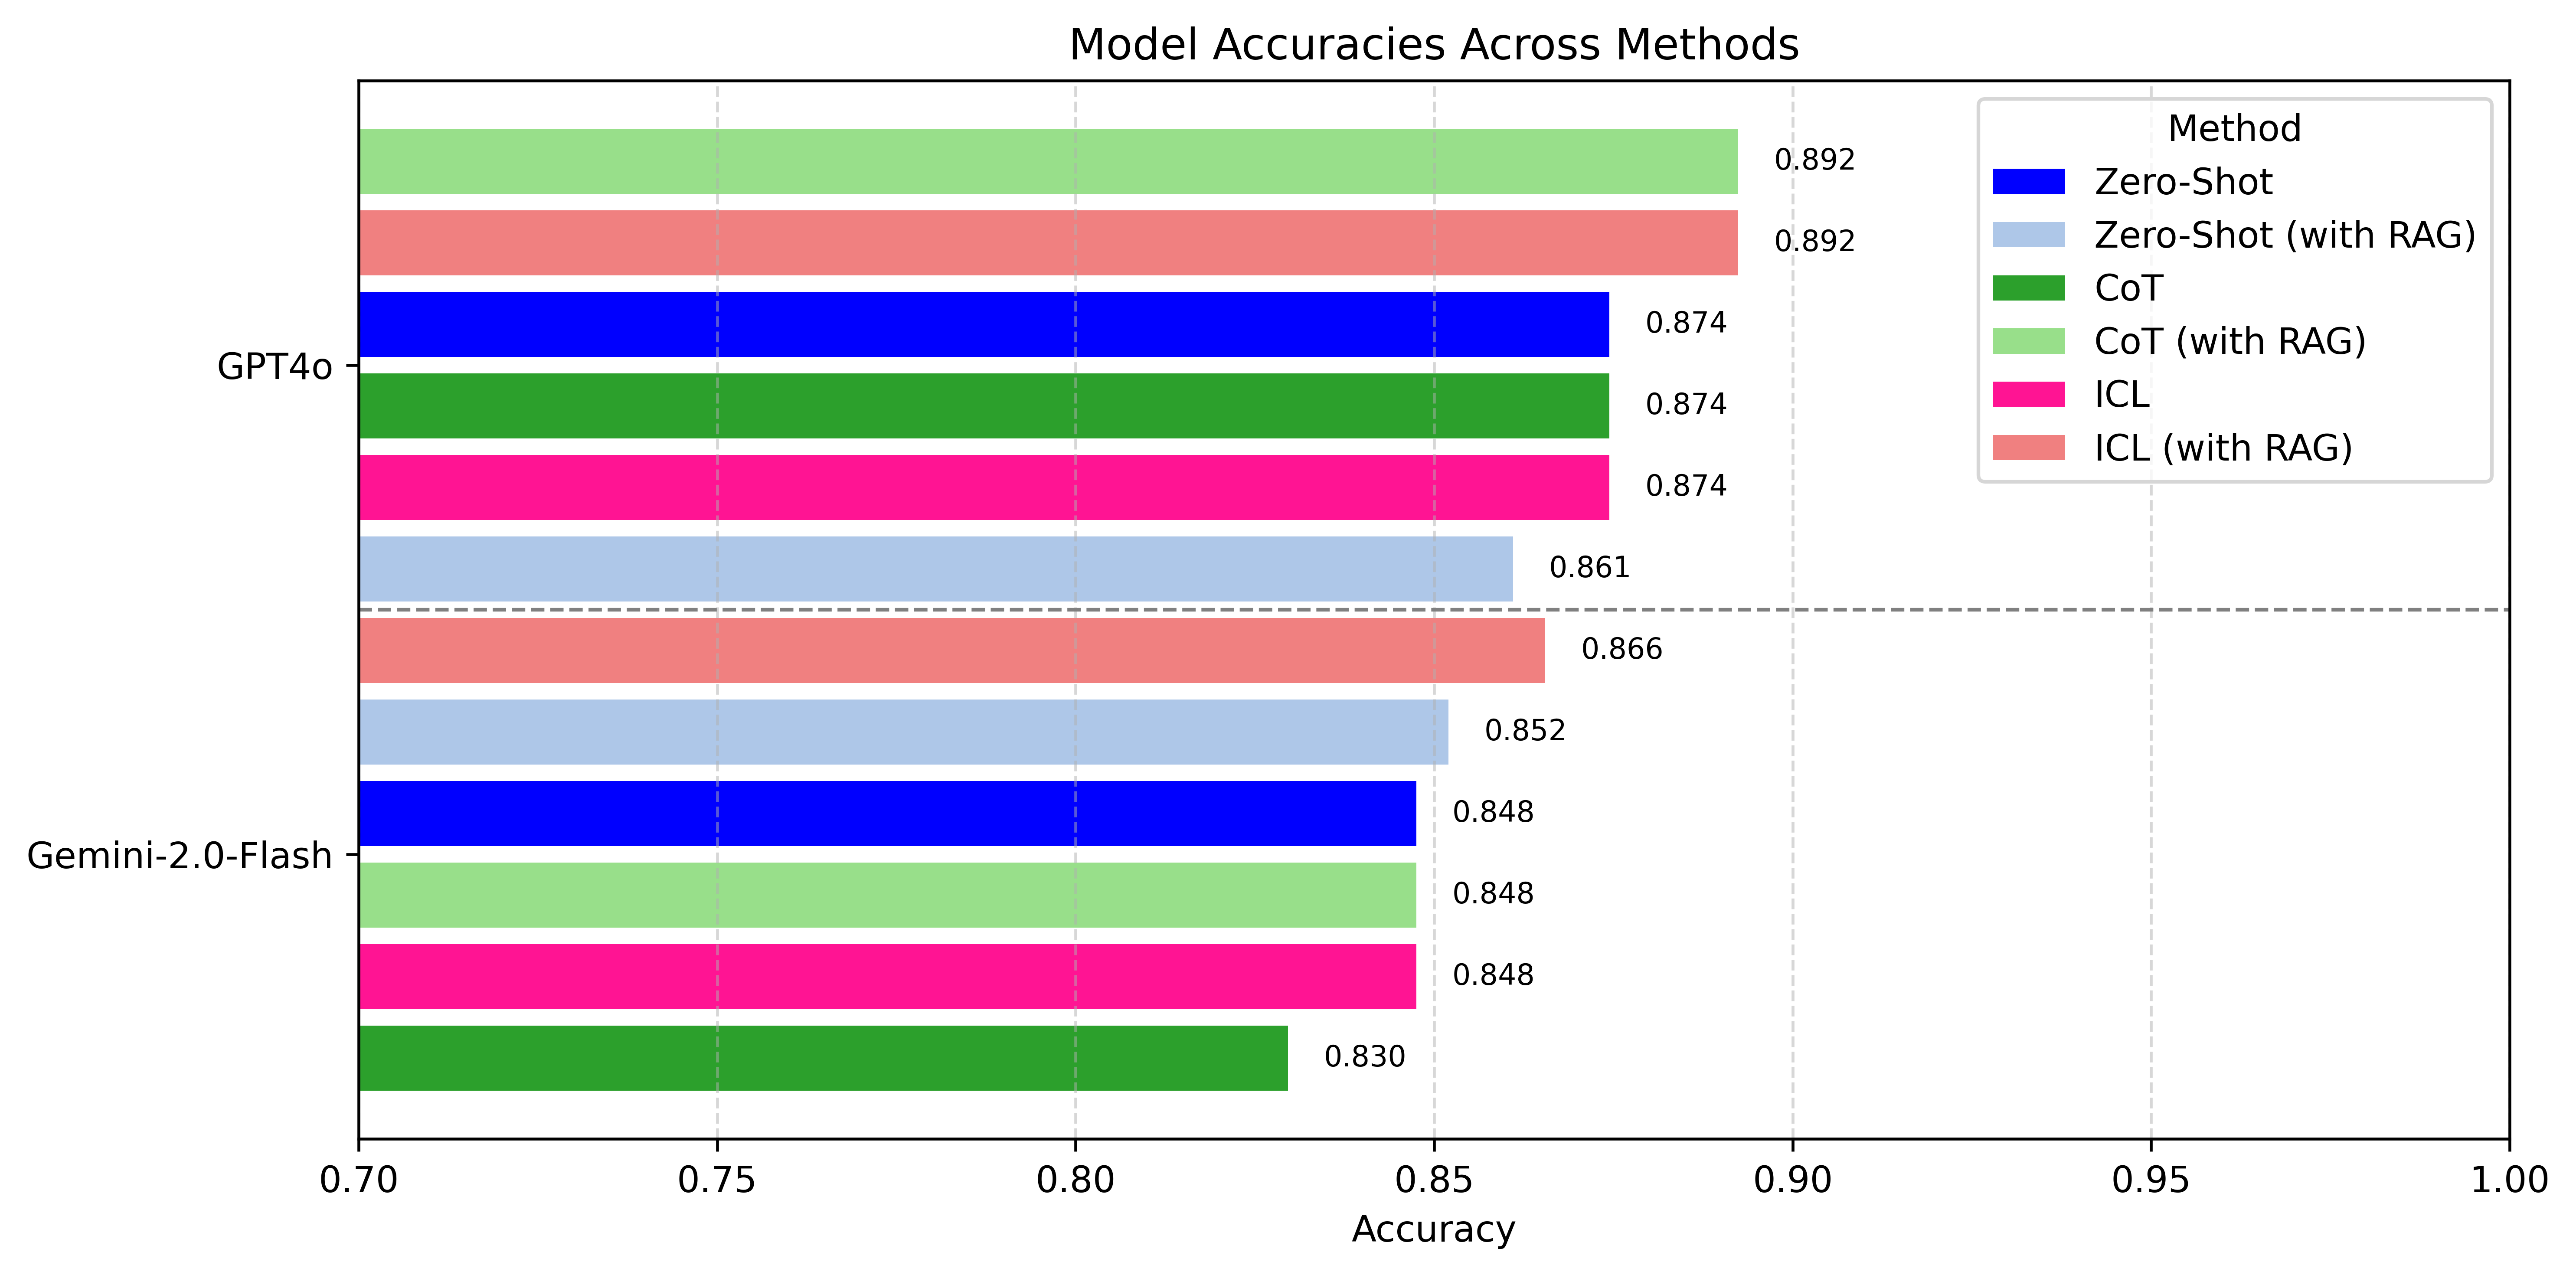

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# Updated data
data = {
    'GPT4o': {
        'Zero-Shot': 0.8744,
        'Zero-Shot (with RAG)': 0.8610,
        'CoT': 0.8744,
        'CoT (with RAG)': 0.8924,
        'ICL': 0.8744,
        'ICL (with RAG)': 0.8924,
    },
    'Gemini-2.0-Flash': {
        'Zero-Shot': 0.8475,
        'Zero-Shot (with RAG)': 0.852,
        'CoT': 0.8296,
        'CoT (with RAG)': 0.8475,
        'ICL': 0.8475,
        'ICL (with RAG)': 0.8655,
    }
}

# Flatten to DataFrame
df = pd.DataFrame(data).T.reset_index().melt(id_vars='index', var_name='Method', value_name='Score')
df.rename(columns={'index': 'Model'}, inplace=True)

# Sort by model then method order
method_order = ['Zero-Shot', 'Zero-Shot (with RAG)', 'CoT', 'CoT (with RAG)', 'ICL', 'ICL (with RAG)']
df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)
df = df.sort_values(['Model', 'Score'], ascending=[True, False])

# Build labels
df['Label'] = df['Method'].astype(str) + ' - ' + df['Model']

# Assign color by method
method_palette = {
    'Zero-Shot': '#0000ff',
    'Zero-Shot (with RAG)': '#aec7e8',
    'CoT': '#2ca02c',
    'CoT (with RAG)': '#98df8a',
    'ICL': '#ff1493',
    'ICL (with RAG)': '#f08080',
}
df['Color'] = df['Method'].map(method_palette)

# Plot
plt.figure(figsize=(10, 5), dpi=600)
bars = plt.barh(df['Label'], df['Score'], color=df['Color'])
for bar in bars:
    plt.text(
        bar.get_width() + 0.005,                 # x-position slightly after the bar end
        bar.get_y() + bar.get_height() / 2,      # y-position centered on the bar
        f"{bar.get_width():.3f}",                # formatted score
        va='center',
        ha='left',
        fontsize=8
    )

# Flip y-axis to show best scores at the top
plt.gca().invert_yaxis()

# Add horizontal lines between models
section_boundaries = df['Model'].value_counts().cumsum().values[:-1]
for boundary in section_boundaries:
    plt.axhline(boundary - 0.5, color='gray', linestyle='--', linewidth=1)

# Set y-axis tick labels to only show the model names at group midpoints
group_sizes = df['Model'].value_counts().values
group_positions = [sum(group_sizes[:i]) + (size - 1) / 2 for i, size in enumerate(group_sizes)]
plt.yticks(group_positions, df['Model'].unique())

# Add legend for method colors
legend_elements = [Patch(facecolor=method_palette[m], label=m) for m in method_order]
plt.legend(handles=legend_elements, title="Method", loc='upper right')

# Aesthetics
plt.xlabel('Accuracy')
plt.title('Model Accuracies Across Methods')
plt.xlim(0.7, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
"""
Plot accuracy of each LLM in multiple choice test as a function of available chunks / token size for RAG:
Each plot is each LLM for a different value of k --> different number of context vectors selected from knowledge corpus
Include horizontal line for baseline accuracy of zero shot model to show what chunk size/ k value causes improvement
"""
models = ["gemini-2.0-flash", 'gpt4o']
k_vals = ["k=3", "k=4", "k=5", "k=6", "k=7"]
data = {
    {
        model: {
            k: []
        } for k in k_vals
     } for model in models

}

### Plot Cumulative RMSEs for each model and variable: RAG

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np

df_processed = pd.read_csv('/content/drive/MyDrive/THESIS/rag-thesis/data/processed_FRED_data.csv')
train_data, test_data, _ = test_train_split(df_processed, test_size=0.3)

# Sample Dates
dates = test_data[:-13].index

# Variables (excluding last one)
variables = ["GDP_log", 'GPDI_log', 'INDPRO_log', 'XTIMVA01USM664S_log','XTEXVA01USM664S_log','B235RC1Q027SBEA', 'RPI_log', 'PCEPI_inflation', 'ROWFDIQ027S']
horizons = ["h=1", "h=3", "h=6", "h=12"]

for horizon in horizons:
    fig, axs = plt.subplots(3, 3, figsize=(14, 10), dpi=600)
    axs = axs.flatten()

    for i, target in enumerate(variables):
        ax = axs[i]

        # Compute point-differences
        timegpt_diff = [timegpt_results[horizon]['cum_RMSE'][target][0]] + [timegpt_results[horizon]['cum_RMSE'][target][i] - timegpt_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(timegpt_results[horizon]['cum_RMSE'][target]))]
        timesfm_diff = [timesfm_results[horizon]['cum_RMSE'][target][0]] + [timesfm_results[horizon]['cum_RMSE'][target][i] - timesfm_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(timesfm_results[horizon]['cum_RMSE'][target]))]
        moirai_diff = [moirai_results[horizon]['cum_RMSE'][target][0]] + [moirai_results[horizon]['cum_RMSE'][target][i] - moirai_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(moirai_results[horizon]['cum_RMSE'][target]))]
        chronos_diff = [chronos_results[horizon]['cum_RMSE'][target][0]] + [chronos_results[horizon]['cum_RMSE'][target][i] - chronos_results[horizon]['cum_RMSE'][target][i - 1] for i in range(1, len(chronos_results[horizon]['cum_RMSE'][target]))]

        timegpt_rag_diff = [x - y for x, y in zip(timegpt_diff, timegpt_rag_results[horizon]['rmses'][target])]
        timesfm_rag_diff = [x - y for x, y in zip(timesfm_diff, timesfm_rag_results[horizon]['rmses'][target])]
        moirai_rag_diff = [x - y for x, y in zip(moirai_diff, moirai_rag_results[horizon]['rmses'][target])]
        chronos_rag_diff = [x - y for x, y in zip(chronos_diff, chronos_rag_results[horizon]['rmses'][target])]

        timegpt_diff = np.cumsum(timegpt_diff).tolist()
        timesfm_diff = np.cumsum(timesfm_diff).tolist()
        moirai_diff = np.cumsum(moirai_diff).tolist()
        chronos_diff = np.cumsum(chronos_diff).tolist()

        timegpt_rag_diff = np.cumsum(timegpt_rag_diff).tolist()
        timesfm_rag_diff = np.cumsum(timesfm_rag_diff).tolist()
        moirai_rag_diff = np.cumsum(moirai_rag_diff).tolist()
        chronos_rag_diff = np.cumsum(chronos_rag_diff).tolist()

        df = pd.DataFrame({
            "Date": dates,
            "TimesFM": timesfm_diff,
            "TimeGPT": timegpt_diff,
            "TimeGPT (RAG)": timegpt_rag_diff,
            "TimesFM (RAG)": timesfm_rag_diff

        })

        df3 = pd.DataFrame({
            "Date": dates[:-5],
            "Moirai": moirai_diff,
            "Moirai (RAG)": moirai_rag_diff
        })

        df4 = pd.DataFrame({
            "Date": dates,
            "Chronos": chronos_diff,
            "Chronos (RAG)": chronos_rag_diff
        })

        # Plot
        ax.plot(df3["Date"], df3["Moirai (RAG)"], color="#ee4fee", linestyle="-")
        ax.plot(df["Date"], df["TimeGPT (RAG)"], color="#27d52c", linestyle="-")
        ax.plot(df["Date"], df["TimesFM (RAG)"], color="#9b59b6", linestyle="-")
        ax.plot(df4["Date"], df4["Chronos (RAG)"], color="#f25920", linestyle="-")

        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_title(target, fontsize=10)
        ax.grid(True)

        if i == 0:
            ax.legend(["Moirai", "TimeGPT","TimesFM", "Chronos"], fontsize=8)

    # Hide unused subplot (the 9th plot)
    for j in range(len(variables), 9):
        fig.delaxes(axs[j])

    fig.suptitle(f"Cumulative Difference in RMSE for {horizon}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    #plt.show
    plt.savefig(f'/content/drive/MyDrive/THESIS/rag-thesis/results/cum_rmse/rag_{horizon}_rmse_3x3grid.png')
    plt.close()
